In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.fft import fft
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import SilhouetteVisualizer
import itertools

### Importing dataset

In [2]:
# Importing data

bearing_signals = pd.read_csv('Notrack/bearing_signals.csv')
bearing_classes = pd.read_csv('Notrack/bearing_classes.csv', delimiter=';')

# Dropping and renaming columns
bearing_signals = bearing_signals.drop(['bearing_1_id','experiment_id'], axis=1)
bearing_signals.rename(columns={'bearing_2_id': 'bearing_id'}, inplace=True)

# Merging signals with classes
df = pd.merge(bearing_signals, bearing_classes, on='bearing_id')
df.head()

,bearing_id,timestamp,a1_x,a1_y,a1_z,a2_x,a2_y,a2_z,rpm,hz,w,status
0,1,0.000000,0.113269,0.149706,-0.110275,-0.186030,0.194450,0.454299,0.0,0.0,0.000006,0
1,1,0.000333,-0.367713,-0.228832,0.177821,0.285992,0.002226,-0.043930,0.0,0.0,0.000243,0
2,1,0.000667,0.113269,0.149706,-0.398371,-0.091625,0.002226,0.454299,0.0,0.0,0.000369,0
3,1,0.001000,-0.175320,-0.228832,-0.110275,0.285992,0.002226,0.255007,0.0,0.0,0.000520,0
4,1,0.001333,-0.079124,0.055072,-0.110275,0.191588,0.002226,0.255007,0.0,0.0,0.000175,0


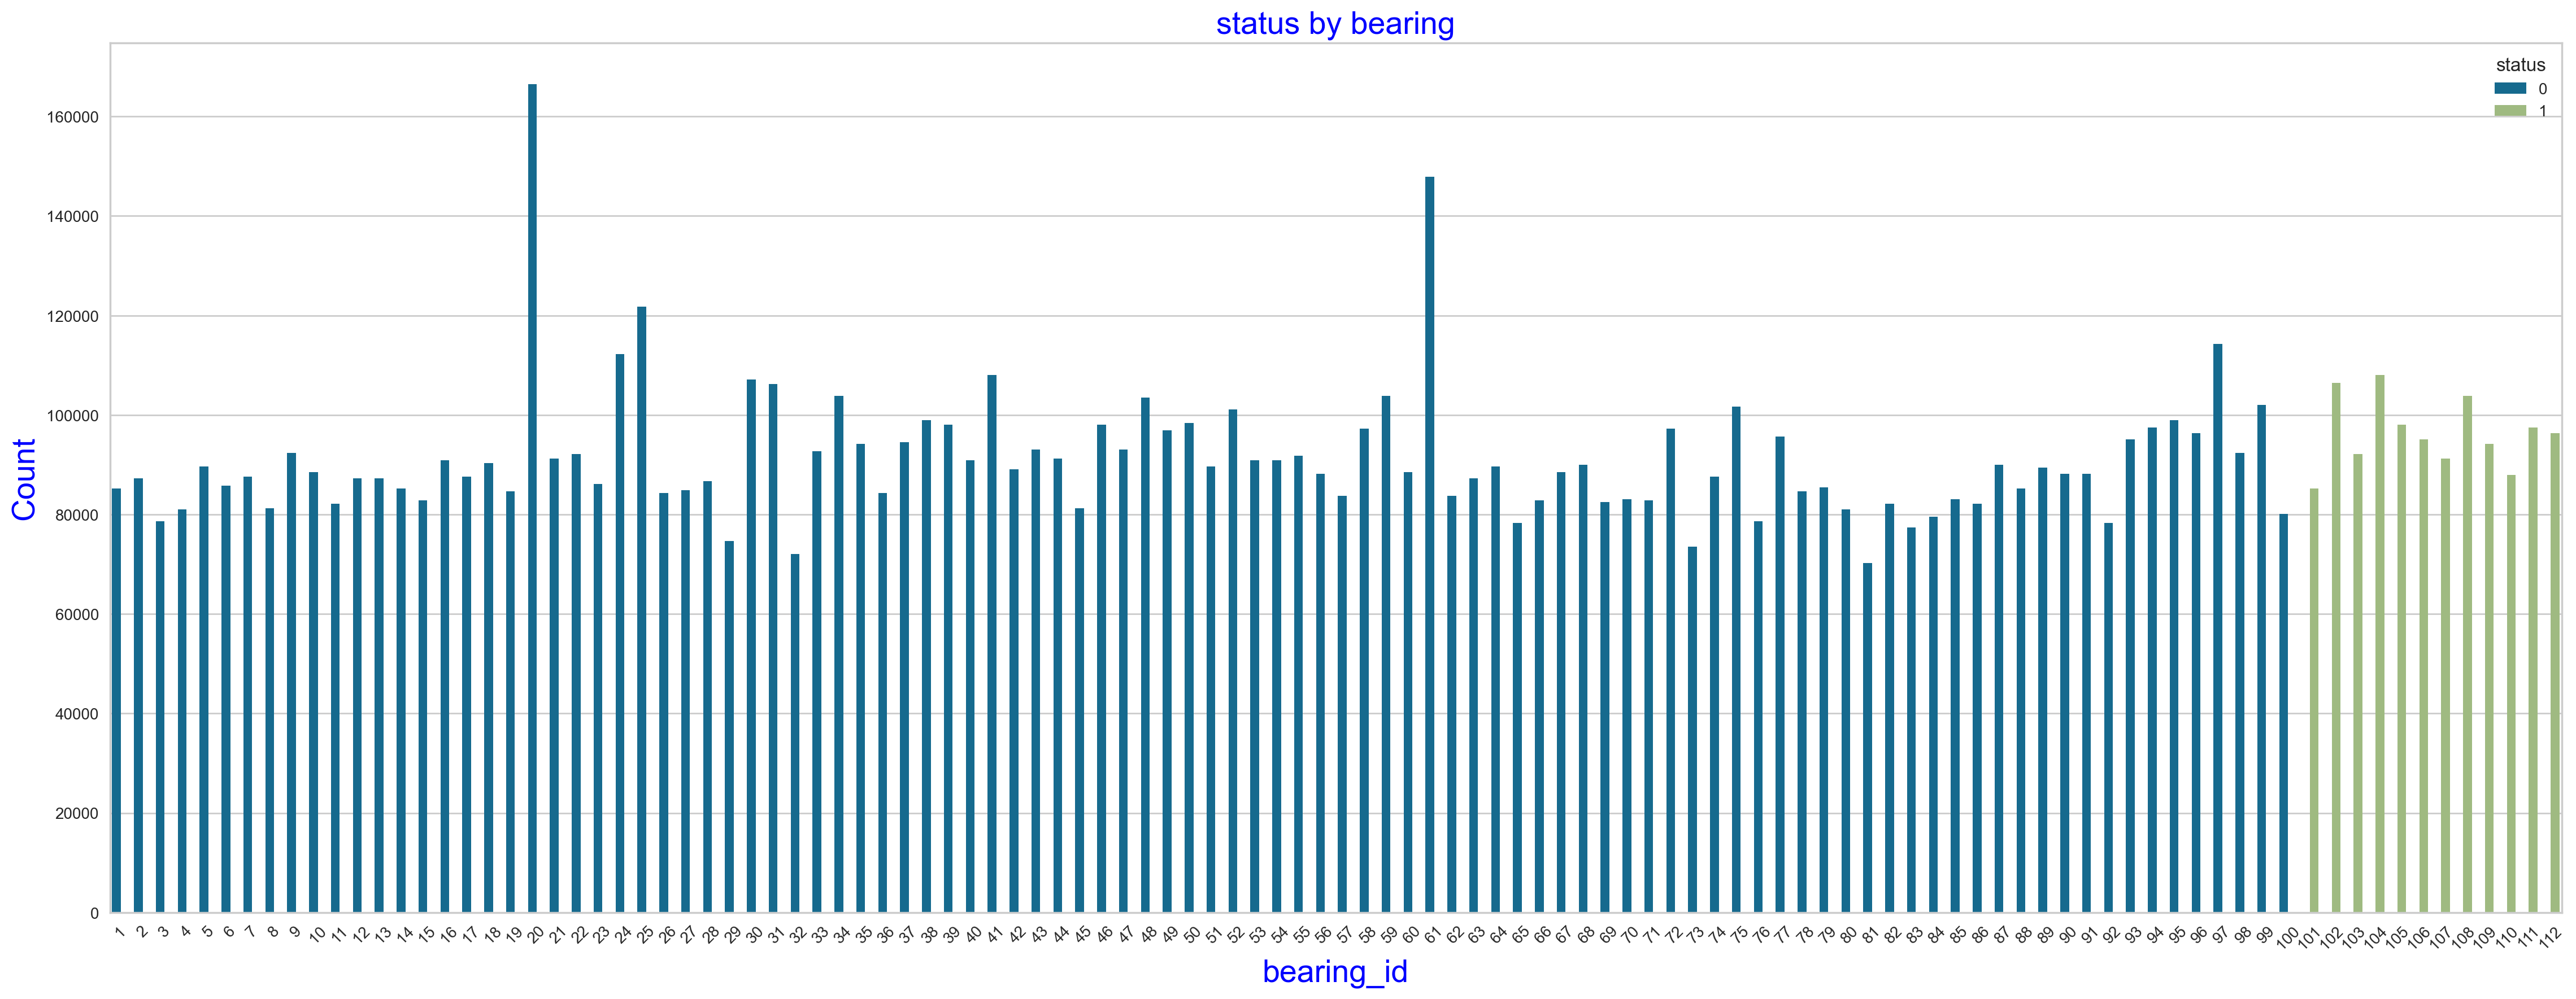

In [3]:
plt.figure(figsize = (28, 10), dpi=200)
sns.countplot(x = 'bearing_id', hue = 'status', data = df)
plt.title('status by bearing', fontdict={'fontsize': 20, 'color': 'blue'})
plt.xlabel('bearing_id', fontdict={'fontsize': 20, 'color': 'blue'})
plt.ylabel('Count', fontdict={'fontsize': 20, 'color': 'blue'})
plt.xticks(rotation=45)
plt.show()

### Gathering Features of failed bearing

In [4]:
df = df[['bearing_id','a2_x','a2_y','a2_z','status']]
N = len(df)

# Computing Fast Fourier Transform of acceleration components

df['a2_xf'] = np.abs(fft(df['a2_x'].values))/N
df['a2_yf'] = np.abs(fft(df['a2_y'].values))/N
df['a2_zf'] = np.abs(fft(df['a2_z'].values))/N
df.head()

,bearing_id,a2_x,a2_y,a2_z,status,a2_xf,a2_yf,a2_zf
0,1,-0.186030,0.194450,0.454299,0,0.312419,0.087583,0.071022
1,1,0.285992,0.002226,-0.043930,0,0.149880,0.081023,0.040852
2,1,-0.091625,0.002226,0.454299,0,0.108475,0.031077,0.061023
3,1,0.285992,0.002226,0.255007,0,0.069498,0.030951,0.035565
4,1,0.191588,0.002226,0.255007,0,0.031704,0.067624,0.043563


In [5]:
df_mean = df.groupby('bearing_id').mean()
df_mean = df_mean.drop('status',axis=1)
df_mean.columns = ['a2_x_mean','a2_y_mean','a2_z_mean','a2_xf_mean','a2_yf_mean','a2_zf_mean']
df_mean.head()

,a2_x_mean,a2_y_mean,a2_z_mean,a2_xf_mean,a2_yf_mean,a2_zf_mean
bearing_id,,,,,,
1,0.114590,0.023329,0.250710,0.001660,0.001801,0.001620
2,-0.178986,0.024936,0.194061,0.001982,0.002687,0.001612
3,-0.121842,0.036149,0.183881,0.001506,0.001733,0.001219
4,-0.119574,0.030838,0.200699,0.001339,0.001079,0.001149
5,-0.080799,0.034042,0.206547,0.001374,0.000679,0.001335


In [6]:
df_max = df.groupby('bearing_id').max()
df_max = df_max.drop('status',axis=1)
df_max.columns = ['a2_x_max','a2_y_max','a2_z_max','a2_xf_max','a2_yf_max','a2_zf_max']
df_max.head()

,a2_x_max,a2_y_max,a2_z_max,a2_xf_max,a2_yf_max,a2_zf_max
bearing_id,,,,,,
1,8.687975,9.228967,11.813929,0.312419,0.087583,0.071022
2,8.310358,8.748408,8.924198,0.017958,0.042445,0.025433
3,9.632018,10.190086,7.927740,0.012471,0.014712,0.011565
4,7.649527,7.883401,7.828094,0.015369,0.013449,0.009459
5,9.254401,9.709526,9.223136,0.010306,0.006432,0.010904


In [7]:
df_min = df.groupby('bearing_id').min()
df_min = df_min.drop('status',axis=1)
df_min.columns = ['a2_x_min','a2_y_min','a2_z_min','a2_xf_min','a2_yf_min','a2_zf_min']
df_max.head()

,a2_x_max,a2_y_max,a2_z_max,a2_xf_max,a2_yf_max,a2_zf_max
bearing_id,,,,,,
1,8.687975,9.228967,11.813929,0.312419,0.087583,0.071022
2,8.310358,8.748408,8.924198,0.017958,0.042445,0.025433
3,9.632018,10.190086,7.927740,0.012471,0.014712,0.011565
4,7.649527,7.883401,7.828094,0.015369,0.013449,0.009459
5,9.254401,9.709526,9.223136,0.010306,0.006432,0.010904


In [8]:
df_master = pd.merge(df_mean, df_max, on='bearing_id')
df_master = pd.merge(df_master, df_min, on='bearing_id')
df_master.head().T

bearing_id,1,2,3,4,5
a2_x_mean,1.145904e-01,-0.178986,-0.121842,-0.119574,-0.080799
a2_y_mean,2.332918e-02,0.024936,0.036149,0.030838,0.034042
a2_z_mean,2.507103e-01,0.194061,0.183881,0.200699,0.206547
a2_xf_mean,1.660094e-03,0.001982,0.001506,0.001339,0.001374
a2_yf_mean,1.801156e-03,0.002687,0.001733,0.001079,0.000679
a2_zf_mean,1.620476e-03,0.001612,0.001219,0.001149,0.001335
a2_x_max,8.687975e+00,8.310358,9.632018,7.649527,9.254401
a2_y_max,9.228967e+00,8.748408,10.190086,7.883401,9.709526
a2_z_max,1.181393e+01,8.924198,7.927740,7.828094,9.223136
a2_xf_max,3.124191e-01,0.017958,0.012471,0.015369,0.010306


In [9]:
df_max.columns = ['a2_x_range','a2_y_range','a2_z_range','a2_xf_range','a2_yf_range','a2_zf_range']
df_min.columns = ['a2_x_range','a2_y_range','a2_z_range','a2_xf_range','a2_yf_range','a2_zf_range']
df_range = df_max.subtract(df_min, fill_value=0)
df_range.head()

,a2_x_range,a2_y_range,a2_z_range,a2_xf_range,a2_yf_range,a2_zf_range
bearing_id,,,,,,
1,18.692052,17.876810,22.021738,0.312418,0.087581,0.071019
2,17.748009,16.723468,20.028821,0.017956,0.042437,0.025424
3,21.712990,18.645705,19.132008,0.012467,0.014703,0.011554
4,17.653605,15.666237,18.932716,0.015363,0.013446,0.009457
5,20.580138,18.549593,17.039445,0.010305,0.006430,0.010903


In [10]:
df_master = pd.merge(df_master, df_range, on='bearing_id')
print(df_master.shape)
print(df_master.columns)
df_master.head().T

(112, 24)
Index(['a2_x_mean', 'a2_y_mean', 'a2_z_mean', 'a2_xf_mean', 'a2_yf_mean',
       'a2_zf_mean', 'a2_x_max', 'a2_y_max', 'a2_z_max', 'a2_xf_max',
       'a2_yf_max', 'a2_zf_max', 'a2_x_min', 'a2_y_min', 'a2_z_min',
       'a2_xf_min', 'a2_yf_min', 'a2_zf_min', 'a2_x_range', 'a2_y_range',
       'a2_z_range', 'a2_xf_range', 'a2_yf_range', 'a2_zf_range'],
      dtype='object')


bearing_id,1,2,3,4,5
a2_x_mean,1.145904e-01,-0.178986,-0.121842,-0.119574,-0.080799
a2_y_mean,2.332918e-02,0.024936,0.036149,0.030838,0.034042
a2_z_mean,2.507103e-01,0.194061,0.183881,0.200699,0.206547
a2_xf_mean,1.660094e-03,0.001982,0.001506,0.001339,0.001374
a2_yf_mean,1.801156e-03,0.002687,0.001733,0.001079,0.000679
a2_zf_mean,1.620476e-03,0.001612,0.001219,0.001149,0.001335
a2_x_max,8.687975e+00,8.310358,9.632018,7.649527,9.254401
a2_y_max,9.228967e+00,8.748408,10.190086,7.883401,9.709526
a2_z_max,1.181393e+01,8.924198,7.927740,7.828094,9.223136
a2_xf_max,3.124191e-01,0.017958,0.012471,0.015369,0.010306


In [11]:
# saving cleaned dataframe to .csv file
df_master.to_csv('bearings_clustering.csv', encoding='utf-8', index=False)

# Feature of the failed bearings 
df_master = df_master.loc[1:100] # failed bearings are those whose bearing_id is between 1 and 100 inclusive
df_master.shape

(100, 24)

### kmeans clustering of at least two features of the failed bearings

C:\Users\miche\anaconda3\envs\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


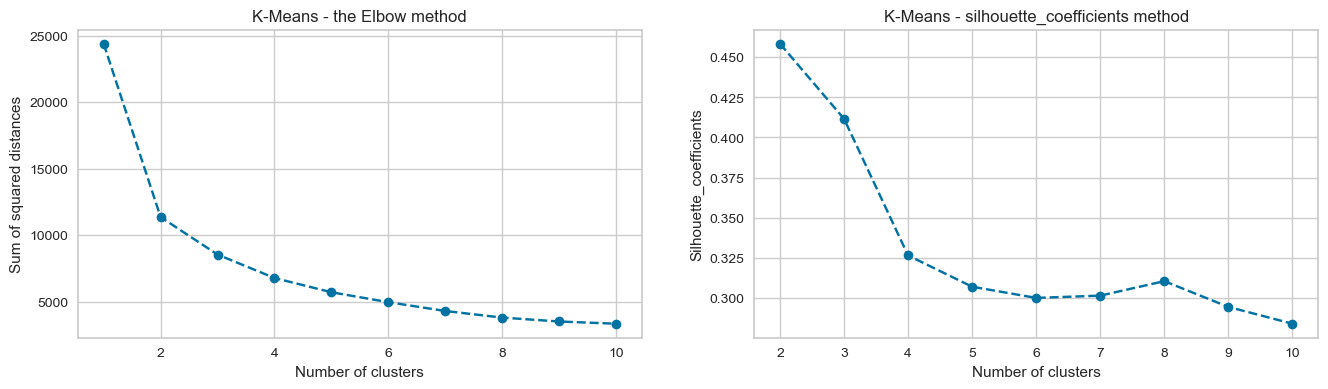

In [12]:
X = df_master #[['a2_x_mean','a2_xf_mean']]

# scaling
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

sum_sqrd = []
silhouette_coefficients = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    km = KMeans(n_clusters = i+1, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    km.fit(X)
    # inertia_: Sum of squared distances of samples to their closest cluster center.
    sum_sqrd.append(kmeans.inertia_) 
    # silhouette score
    silhouette_coefficients.append(silhouette_score(X, km.labels_))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))
ax1.plot(range(1, 11), sum_sqrd, 'o--')
ax1.set_title('K-Means - the Elbow method')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Sum of squared distances')
ax2.plot(range(2, 11), silhouette_coefficients[:-1], 'o--')
ax2.set_title('K-Means - silhouette_coefficients method')
ax2.set_xlabel('Number of clusters')
ax2.set_ylabel('Silhouette_coefficients')
plt.grid(b=True)
plt.show()

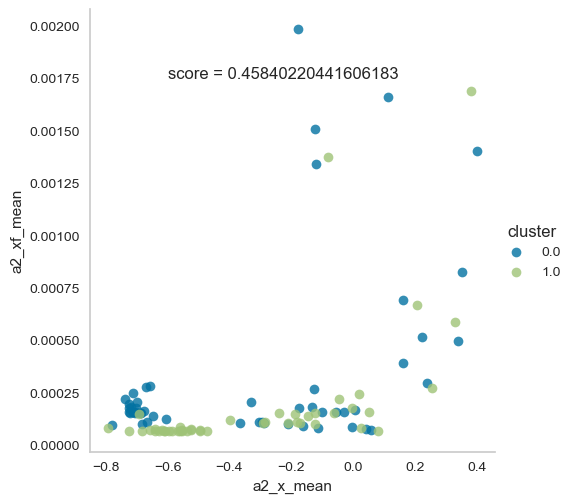

In [13]:
# fit a kmeans object to the dataset
kmeans = KMeans(n_clusters=2, init='k-means++', random_state=42).fit(X)
# clusters is an attribute of the object
cluster_centers = kmeans.cluster_centers_
# score
score = silhouette_score(X, kmeans.labels_)

# add cluster index to dataframe
cluster_labels = pd.Series(kmeans.labels_, name='cluster')
df_kmean = X.join(cluster_labels.to_frame())

sns.lmplot(x='a2_x_mean', y='a2_xf_mean', data=df_kmean, fit_reg=False, hue='cluster')
plt.text(-0.6,0.00175, s='score = '+str(score))
plt.grid()
plt.show()

In [14]:
def kmeans_model(k,cols):
    
    df_kmean = df_master[cols]
    # scaling
    scaler = StandardScaler()
    df_kmean = scaler.fit_transform(df_kmean)
    # fit a kmeans object to the dataset
    model = KMeans(n_clusters=k, init='k-means++', random_state=42).fit(df_kmean)
    # clusters is an attribute of the object
    cluster_centers = model.cluster_centers_
    # inertia
    ssd = model.inertia_
    # score
    score = silhouette_score(df_kmean, model.labels_)

    # add cluster index to dataframe
    cluster_labels = pd.Series(model.labels_, name='cluster')
    df_kmean = df_kmean.join(cluster_labels.to_frame())
    
    return (ssd, score, model, df_kmean)
    sns.lmplot(x=cols[0], y=cols[1], data=df_kmean, fit_reg=False, hue='cluster')
    plt.grid()
    plt.show()

def sil_score(k, cols):
    df_kmean = df_master[list(cols)]
    # scaling
    scaler = StandardScaler()
    df_kmean = scaler.fit_transform(df_kmean)
    # fit a kmeans object to the dataset
    model = KMeans(n_clusters=k, init='k-means++', random_state=42).fit(df_kmean)
    score = silhouette_score(df_kmean, model.labels_)

    return score


def elbow_silhouette(cols):
    
    sum_sqrd = []
    silhouette_coefficients = []

    for i in range(1, 11):

        # inertia_: Sum of squared distances of samples to their closest cluster center.
        sum_sqrd.append(kmeans_model(i,cols)[0]) 
        # silhouette score
        silhouette_coefficients.append(kmeans_model(i+1,cols)[1])

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))
    ax1.plot(range(1, 11), sum_sqrd, 'o--')
    ax1.set_title('K-Means - the Elbow method')
    ax1.set_xlabel('Number of clusters')
    ax1.set_ylabel('Sum of squared distances')
    ax2.plot(range(2, 11), silhouette_coefficients[:-1], 'o--')
    ax2.set_title('K-Means - silhouette_coefficients method')
    ax2.set_xlabel('Number of clusters')
    ax2.set_ylabel('Silhouette_coefficients')
    plt.grid(b=True)
    plt.show()

In [15]:
for col in list(itertools.combinations(df_master.columns[:6],2)):
    print(f'{col} - score: {sil_score(2, col)}')

('a2_x_mean', 'a2_y_mean') - score: 0.789707144181425
('a2_x_mean', 'a2_z_mean') - score: 0.7617601473126885
('a2_x_mean', 'a2_xf_mean') - score: 0.6405794172124178
('a2_x_mean', 'a2_yf_mean') - score: 0.5538488043076348
('a2_x_mean', 'a2_zf_mean') - score: 0.5814978866404403
('a2_y_mean', 'a2_z_mean') - score: 0.8908774179129331
('a2_y_mean', 'a2_xf_mean') - score: 0.846302836392041
('a2_y_mean', 'a2_yf_mean') - score: 0.8634674905215662
('a2_y_mean', 'a2_zf_mean') - score: 0.8006079094011895
('a2_z_mean', 'a2_xf_mean') - score: 0.7620388970259198
('a2_z_mean', 'a2_yf_mean') - score: 0.829939782860597
('a2_z_mean', 'a2_zf_mean') - score: 0.5761035681594867
('a2_xf_mean', 'a2_yf_mean') - score: 0.8756271958367003
('a2_xf_mean', 'a2_zf_mean') - score: 0.7498843987349554
('a2_yf_mean', 'a2_zf_mean') - score: 0.7167803036241606


In [16]:
for col in list(itertools.combinations(df_master.columns[6:12],2)):
    print(f'{col} - score: {sil_score(2, col)}')

('a2_x_max', 'a2_y_max') - score: 0.6314413253463144
('a2_x_max', 'a2_z_max') - score: 0.44818923506794517
('a2_x_max', 'a2_xf_max') - score: 0.876524357662878
('a2_x_max', 'a2_yf_max') - score: 0.8466435051217901
('a2_x_max', 'a2_zf_max') - score: 0.8485137715445461
('a2_y_max', 'a2_z_max') - score: 0.457074482593208
('a2_y_max', 'a2_xf_max') - score: 0.8748432600452203
('a2_y_max', 'a2_yf_max') - score: 0.8073485157578717
('a2_y_max', 'a2_zf_max') - score: 0.5642148680585474
('a2_z_max', 'a2_xf_max') - score: 0.8787439964199946
('a2_z_max', 'a2_yf_max') - score: 0.8151714847621584
('a2_z_max', 'a2_zf_max') - score: 0.851481850299229
('a2_xf_max', 'a2_yf_max') - score: 0.9723814690297288
('a2_xf_max', 'a2_zf_max') - score: 0.9635981886290446
('a2_yf_max', 'a2_zf_max') - score: 0.9536479009513101


In [18]:
for col in list(itertools.combinations(df_master.columns[12:18],2)):
    print(f'{col} - score: {sil_score(2, col)}')

('a2_x_min', 'a2_y_min') - score: 0.4558929684040465
('a2_x_min', 'a2_z_min') - score: 0.4435311086246361
('a2_x_min', 'a2_xf_min') - score: 0.4814439341938084
('a2_x_min', 'a2_yf_min') - score: 0.5206917764347373
('a2_x_min', 'a2_zf_min') - score: 0.4909623276234614
('a2_y_min', 'a2_z_min') - score: 0.4236860752993664
('a2_y_min', 'a2_xf_min') - score: 0.5877164132809919
('a2_y_min', 'a2_yf_min') - score: 0.8025712934126032
('a2_y_min', 'a2_zf_min') - score: 0.4806864081702074
('a2_z_min', 'a2_xf_min') - score: 0.4103261706668613
('a2_z_min', 'a2_yf_min') - score: 0.8005035617716152
('a2_z_min', 'a2_zf_min') - score: 0.3932358095455355
('a2_xf_min', 'a2_yf_min') - score: 0.8260548590126154
('a2_xf_min', 'a2_zf_min') - score: 0.6965922081261892
('a2_yf_min', 'a2_zf_min') - score: 0.8809028721066922


In [19]:
for col in list(itertools.combinations(df_master.columns[18:],2)):
    print(f'{col} - score: {sil_score(2, col)}')

('a2_x_range', 'a2_y_range') - score: 0.5913395249536114
('a2_x_range', 'a2_z_range') - score: 0.4631000992226593
('a2_x_range', 'a2_xf_range') - score: 0.875120400919979
('a2_x_range', 'a2_yf_range') - score: 0.8451417963311908
('a2_x_range', 'a2_zf_range') - score: 0.8473812401201777
('a2_y_range', 'a2_z_range') - score: 0.46833729154153586
('a2_y_range', 'a2_xf_range') - score: 0.8739239286328209
('a2_y_range', 'a2_yf_range') - score: 0.8057596467974208
('a2_y_range', 'a2_zf_range') - score: 0.845994425538695
('a2_z_range', 'a2_xf_range') - score: 0.8764258021250345
('a2_z_range', 'a2_yf_range') - score: 0.8466053900963609
('a2_z_range', 'a2_zf_range') - score: 0.8488157804196748
('a2_xf_range', 'a2_yf_range') - score: 0.9723861071010148
('a2_xf_range', 'a2_zf_range') - score: 0.9636106791884397
('a2_yf_range', 'a2_zf_range') - score: 0.9536644521712122
